# Generative Adversarial Networks   (Vanilla)

> Goodfellow I, Pouget-Abadie J, Mirza M, Xu B, Warde-Farley D, Ozair S, Courville A, Bengio Yoshua

## 0A. Imports

#### **!! INTERACTIVE CELL !!**
##### wandb Logger: Needs login key!

In [90]:
!pip -qqq install wandb pytorch-lightning torchmetrics

import wandb
from pytorch_lightning.loggers import WandbLogger

wandb.login()

# API Key:
# d926baa25b6a14ffa4e5c30a6f3bbffbeca8fcf1

True

In [ ]:
# Use in case wandb fails
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


#### Pytorch-Lightning (Don't open... very large installation output)

In [91]:
try:
  import lightning.pytorch as pl
except:
  print("[!] Couldn't find pytorch-lightning.\nInstalling it...\n")
  !pip install lightning > /dev/null
  import lightning.pytorch as pl

In [92]:
from lightning.pytorch.utilities.model_summary import ModelSummary

#### Standard imports

In [93]:
import os
import shutil
import pathlib

import numpy as np
import cv2 as cv
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset

import torchvision
from torchvision import datasets

try:
    from torchinfo import summary
except:
    print("[!] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [94]:
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor

#### Albumentations 

In [95]:
try:
  import albumentations as A
  from albumentations.pytorch import ToTensorV2
except:
  print("[!] Couldn't find albumentations... installing it.")
  !pip install -U albumentations
  import albumentations as A
  from albumentations.pytorch import ToTensorV2

In [96]:
from pytorch_lightning import seed_everything

#### Seeds (lightning)

In [97]:
seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

#### Device set up: 

In [98]:
# device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

device

device(type='cuda')

## 0B. Utilities

In [99]:
# Folder Utilities ----------------------------

## Create dir if it doesn't exist
def create_dir(dir_name):
  if not os.path.exists(f'/content/{dir_name}'):
    os.mkdir(f'/content/{dir_name}')

## Delete dir: checkpoints
def delete_dir(dir_name):
  if os.path.isdir(f'/content/{dir_name}'):
    shutil.rmtree(f'/content/{dir_name}')

# ---------------------------------------------

## 1. Transforms & Datasets 

Dataset-1: FashionMNIST

#### TODO: Play around with the transforms as experiments - Report

### Transforms

In [154]:
train_transform = Compose(
    [
        # T.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.8,1.2)), # 1
        # T.RandomHorizontalFlip(p=0.5), # 2
        # T.GaussianBlur(kernel_size=3), # 3
        ToTensor(),
    ]
)

In [155]:
test_transform = Compose([ToTensor()])

### Dataset Download & Transformation

In [156]:
train_fashion = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=train_transform,
    target_transform=None
)

train_fashion, val_fashion = random_split(train_fashion, [55000, 5000])

test_fashion = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [157]:
print("Train samples:", len(train_fashion), "| Test samples:" , len(test_fashion), "| Val samples:", len(val_fashion))

Train samples: 55000 | Test samples: 10000 | Val samples: 5000


### Sanity Visualization

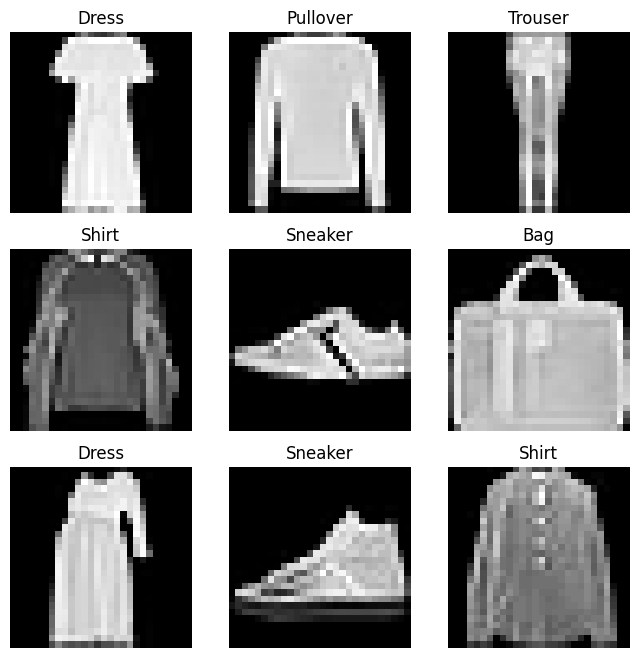

In [158]:
labels_map = {i: x for i,x in enumerate(test_fashion.classes)}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_fashion), size=(1,)).item()
    img, label = train_fashion[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 2. Dataloader:   

Params:   
> BS: *32* , Shuffle = *True*

In [159]:
train_dataloader = DataLoader(train_fashion, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_fashion, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_fashion, batch_size=32, shuffle=True)

## 3. Model Architecture

### Discriminator:

In [160]:
class Discriminator(nn.Module):
  def __init__(self, img_shape):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(int(np.prod(img_shape)), 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, 128),
        nn.ReLU(inplace=True),   
        nn.Linear(128,1),
        nn.Sigmoid() 
    )
  
  def forward(self, x):
    x = x.view(x.size(0), -1)
    real_or_fake = self.model(x)
    return real_or_fake

### Generator:

In [161]:
class Generator(nn.Module):
  def __init__(self, img_shape, latent_dim: int = 100):
    super().__init__()

    self.img_shape = img_shape

    # Paper says nothing about batchNorm?
    self.model = nn.Sequential(
        nn.Linear(latent_dim, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 784),
        nn.Sigmoid()          # Implementation detail: As per paper
    )
  
  def forward(self, z):
    img = self.model(z)
    img = img.view(img.size(0), *self.img_shape)
    return img

## 4. Frechet Inception Distance

In [162]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = torchvision.models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        if inp.shape[1] == 1:
          inp = inp.expand(inp.shape[0], 3, *inp.shape[2:])
          print(inp.shape)
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model_inc = InceptionV3([block_idx])
model_inc = model_inc.cuda()


def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = nn.functional.adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


from scipy.linalg import sqrtm
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is:
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2))
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2
    
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = np.linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

## 5. Recipe

In [163]:
class LIT_GAN(pl.LightningModule):
  
  def __init__(self, 
               discriminator_model, 
               generator_model, 
               latent_dim: int = 100, 
               lr: float = 0.003, 
               b1: float = 0.5, 
               b2: float = 0.999,
               disc_steps: int = 1):
    
    super().__init__()
    self.save_hyperparameters(ignore=[discriminator_model, generator_model])
    self.automatic_optimization = False

    self.discriminator = discriminator_model
    self.generator = generator_model

    self.validation_z = torch.randn(8, self.hparams.latent_dim)
  
  def configure_optimizers(self):
    lr = self.hparams.lr
    b1 = self.hparams.b1
    b2 = self.hparams.b2

    optim_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1,b2))
    optim_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1,b2))
    
    return [optim_g, optim_d], []


  def forward(self, z):
    return self.generator(z)


  def adv_loss(self, prob, target):
    loss = F.binary_cross_entropy(prob, target)
    return loss

  def training_step(self, batch, batch_idx):
    imgs, _ = batch
    # print(f"{batch_idx}:: imgs.shape =",imgs.shape)
    imgs = imgs.to(device)

    opt_g, opt_d = self.optimizers()

    z = torch.randn(imgs.shape[0], self.hparams.latent_dim) # N x Z_d
    z = z.type_as(imgs).to(device)

    fake_arr = torch.zeros(imgs.size(0), 1).to(device) # N: 0s
    real_arr = torch.ones(imgs.size(0), 1).to(device) # N: 1s
    # print(f"Disc out shape:", self.discriminator(self(z)).shape)
    # Train G:
    self.toggle_optimizer(opt_g)
    
    # Generator loss:
    g_out = self.forward(z)
    g_loss = self.adv_loss(self.discriminator(self(z)), real_arr) # Fooling the Disc: How Real is the fake output?

    # Grad step:
    # self.log("g_loss", g_loss, prog_bar=True)
    self.manual_backward(g_loss)
    opt_g.step()
    opt_g.zero_grad()
    self.untoggle_optimizer(opt_g)

    # Train Discriminator
    self.toggle_optimizer(opt_d)
    
    # Paper's proposition: To keep D at optimum discriminative power
    # Train it 'k' steps (h-param)
    # Experimentally k is kept at 1
    
    for i in range(self.hparams.disc_steps):
      # Discriminator loss:
      d_loss_real = self.adv_loss(self.discriminator(imgs), real_arr)
      d_loss_fake = self.adv_loss(self.discriminator(self(z)), fake_arr)
      d_loss = (d_loss_fake + d_loss_real) / 2.

      # self.log("d_loss", d_loss, prog_bar=True)
      self.manual_backward(d_loss)
      opt_d.step()
      opt_d.zero_grad()

    self.untoggle_optimizer(opt_d)
    
    self.log_dict({"g_loss": g_loss, "d_loss": d_loss}, prog_bar=True)
    self.logger.experiment.log({"Gen_Image_1 (during training)":[wandb.Image(g_out[0].cpu(), caption="Gen Out")]})

  def validation_step(self, batch, batch_idx):
    imgs, _ = batch

    imgs = imgs.to(device)

    z = torch.randn(imgs.shape[0], self.hparams.latent_dim) # N x Z_d
    z = z.type_as(imgs).to(device)

    fake_arr = torch.zeros(imgs.size(0), 1).to(device) # N: 0s
    real_arr = torch.ones(imgs.size(0), 1).to(device) # N: 1s

    g_out = self.forward(z)
    g_out = g_out[:,None,:,:]
    # print(g_out.shape)
    g_loss = self.adv_loss(self.discriminator(self(z)), real_arr)
    
    d_loss_real = self.adv_loss(self.discriminator(imgs), real_arr)
    d_loss_fake = self.adv_loss(self.discriminator(self(z)), fake_arr)
    d_loss = (d_loss_fake + d_loss_real) / 2

    # self.inception.update(g_out)
    imgs_fid = imgs.expand(imgs.shape[0], 3, *imgs.shape[2:])
    g_out_fid = g_out.expand(g_out.shape[0], 3, *g_out.shape[2:])
    this_fid = calculate_fretchet(imgs_fid, g_out_fid, model_inc)
    print(f"FID: {this_fid:.3f}")

    self.log_dict({"val_g_loss": g_loss, 
                   "val_d_loss": d_loss, 
                   "FID":  this_fid}, on_step=True, on_epoch=True, prog_bar=True)

### Recipe & trainer: initializations

In [164]:
sample_img, sample_target = next(iter(train_dataloader))
sample_img.shape, sample_target.size()

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [165]:
van_gan = LIT_GAN(
      Discriminator(img_shape=(sample_img.size(2), sample_img.size(3))), 
      Generator(img_shape=(sample_img.size(2), sample_img.size(3))), 
      lr=1e-3
    )
summary = ModelSummary(van_gan, max_depth=-1)
print(summary)

   | Name                  | Type          | Params
---------------------------------------------------------
0  | discriminator         | Discriminator | 566 K 
1  | discriminator.model   | Sequential    | 566 K 
2  | discriminator.model.0 | Linear        | 401 K 
3  | discriminator.model.1 | ReLU          | 0     
4  | discriminator.model.2 | Linear        | 131 K 
5  | discriminator.model.3 | ReLU          | 0     
6  | discriminator.model.4 | Linear        | 32.9 K
7  | discriminator.model.5 | ReLU          | 0     
8  | discriminator.model.6 | Linear        | 129   
9  | discriminator.model.7 | Sigmoid       | 0     
10 | generator             | Generator     | 579 K 
11 | generator.model       | Sequential    | 579 K 
12 | generator.model.0     | Linear        | 12.9 K
13 | generator.model.1     | ReLU          | 0     
14 | generator.model.2     | Linear        | 33.0 K
15 | generator.model.3     | ReLU          | 0     
16 | generator.model.4     | Linear        | 131 K 
17 | g

In [166]:
delete_dir("van_gan_exps")
create_dir("van_gan_exps")

## Logger Init

In [167]:
wandb_logger = WandbLogger(project="M1_GAN", 
                           name="exp-5-no_augs",
                           job_type='train_val',
                           log_model="all")

In [168]:
# train model
from lightning.pytorch.callbacks import DeviceStatsMonitor, TQDMProgressBar

trainer = pl.Trainer(default_root_dir="/content/van_gan_exps/", 
                     fast_dev_run=False,
                     logger=wandb_logger,   # wandb <3
                     log_every_n_steps=1,   # set the logging frequency
                     accelerator='auto',
                     devices="auto",        # all
                     max_epochs=5,          # number of epochs
                     deterministic=True,    # keep it deterministic
                     callbacks=[TQDMProgressBar(refresh_rate=10)],
                     )

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


## Training:

In [169]:
# Train model:
trainer.fit(van_gan, train_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params
------------------------------------------------
0 | discriminator | Discriminator | 566 K 
1 | generator     | Generator     | 579 K 
------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.584     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | discriminator | Discriminator | 566 K 
1 | generator     | Generator     | 579 K 
------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.584     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: Network error resolved after 0:00:01.105046, resuming normal operation.
INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


## Validation

In [170]:
print(len(test_dataloader))

313


In [171]:
trainer.validate(model=van_gan, dataloaders=test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

FID: 291.616
FID: 276.018
FID: 289.650
FID: 280.756
FID: 281.333
FID: 307.409
FID: 270.095
FID: 299.875
FID: 280.968
FID: 300.506
FID: 284.109
FID: 262.074
FID: 289.733
FID: 291.482
FID: 267.360
FID: 312.637
FID: 305.884
FID: 291.732
FID: 283.828
FID: 293.164
FID: 295.731
FID: 296.416
FID: 272.912
FID: 283.957
FID: 284.172


## Finish Logger Instance

In [172]:
wandb.finish()

FID_step,▅▃▅▄▄▇▂▆▄▆▄▁▅▅▂█▇▅▄▅▆▆▃▄▄
d_loss,▄▁▄▄▅▄▄▅▅▅▄▆▆▅▄▅▆▅▅▆▅▆▆▆▆▇▆▇▇▆▆█▇▇▇▇▇▇▇▇
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
g_loss,▅█▂▃▂▃▂▂▂▂▁▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_d_loss_step,█▂▆▅▄▅▅▄▂▃▃▄▆▆▇▆▄▅▆▄▅▄▄▁▄
val_g_loss_step,▄▇▂▂▃▆▄▃▁▅▄▆▆▄▃▇▇▁▄▆▇▇▅█▃
FID_step,284.17228
d_loss,0.70322
epoch,4
g_loss,0.76358
